<a href="https://colab.research.google.com/github/Ssurf777/GAN_sample/blob/main/horse2zebra_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import argparse
import glob
import os

import torch
import tqdm
from PIL import Image
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument("--n_epoch", type = int, default=200)
parser.add_argument("--batch_size", type = int, default=1)
parser.add_argument("--lr", type = float, default=2e-4)
parser.add_argument("--decay_start", type = int, default=100)
parser.add_argument("--weight_identity", type = float, default=5.0)
parser.add_argument("--weight_cycle", type = float, default=10.0)
parser.add_argument("--image_size", type = int, default=256)
parser.add_argument("--beta1", type = float, default=0.5)
opt = parser.parse_args(args=[])
print(opt)

Namespace(n_epoch=200, batch_size=1, lr=0.0002, decay_start=100, weight_identity=5.0, weight_cycle=10.0, image_size=256, beta1=0.5)


In [4]:
from torch.utils.data import Dataset
from PIL import Image

class ImageDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.files_A= glob.glob("./drive/MyDrive/Colab Notebooks/GAN/horse2zebra/trainA/*.jpg")
        self.files_B= glob.glob("./drive/MyDrive/Colab Notebooks/GAN/horse2zebra/trainB/*.jpg")
        self.transform = transform

    def __getitem__(self, index):
        imgA = self.transform(Image.open(self.files_A[index % len(self.files_A)]))
        while True:
          random_index = np.random.randint(0, len(self.files_B) - 1)
          imgB = self.transform(Image.open(self.files_B[random_index % len(self.files_B)]))
          C, H, W = imgB.size()
          if C == 3:
            break
        return {"A":imgA, "B":imgB}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [5]:
class DecayLR(object):
    def __init__(self, n_epochs, offset, decay_start_epoch):
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / ( self.n_epochs - self.decay_start_epoch)

In [6]:
class ReplayBuffer(object):
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if np.random.rand() > 0.5:
                    i = np.random.randint(0, self.max_size -1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

# Generator Architechtures

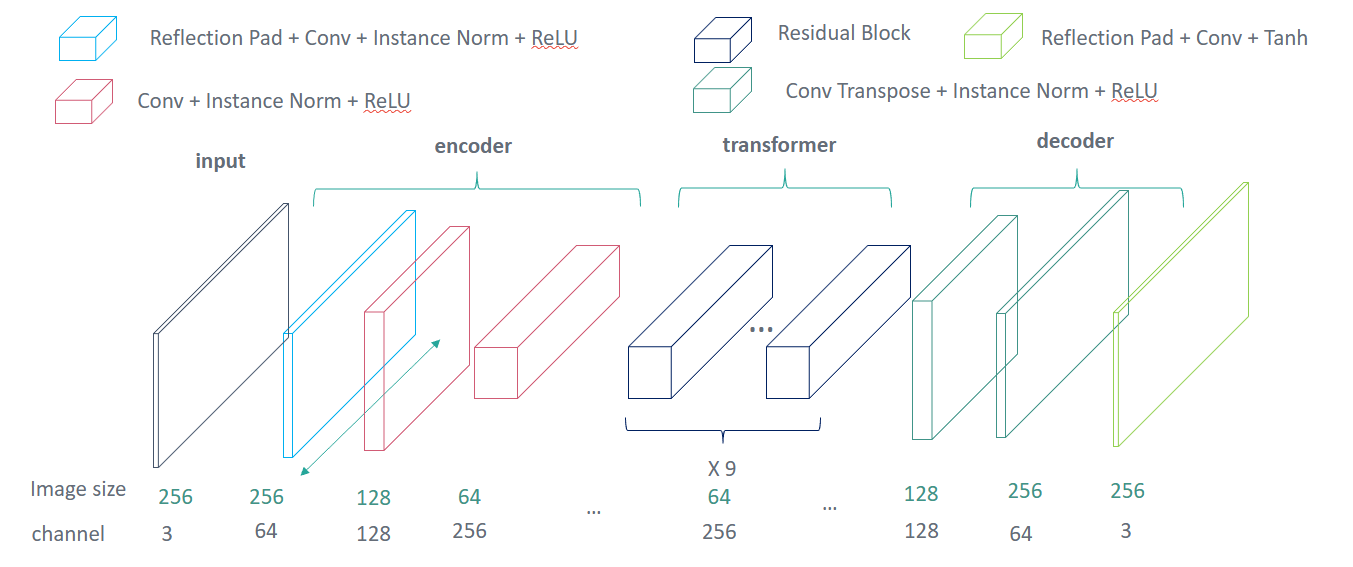

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.ReLU(inplace = True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
        )
    def forward(self, x):
        out = self.conv_layers(x)
        out += x
        return out

class Generator(nn.Module):
    def __init__(self, res_block, in_channels=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.res_block = res_block(256)
        self.transformers = nn.ModuleList( 9 *[self.res_block]) #9層resudual Blockを積層

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7),
            nn.Tanh()
        )
    def forward(self, x):
        out = self.encoder(x)
        for func in self.transformers:
            out = func(out)
        out = self.decoder(out)
        return out

# Discriminator
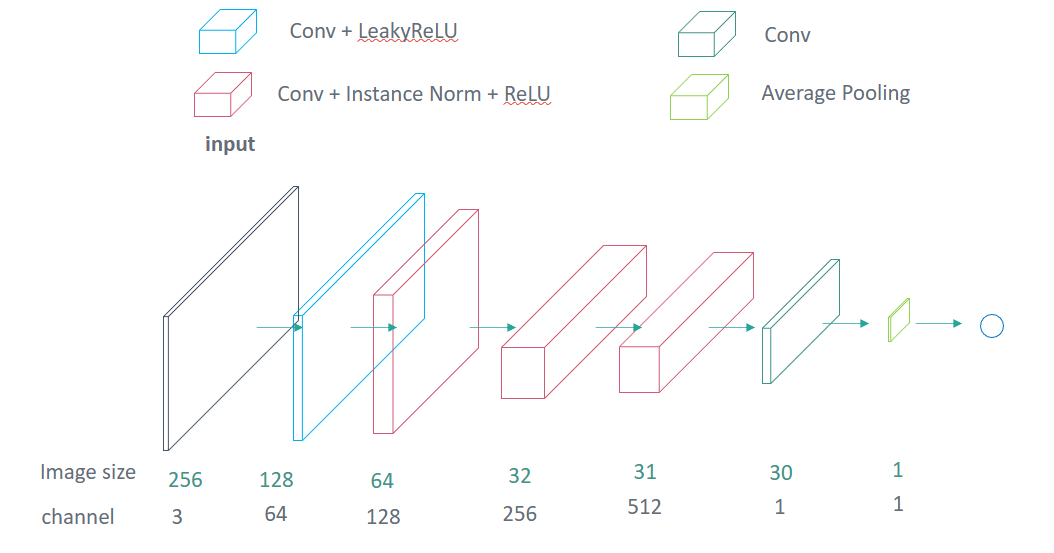

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = self.conv_layers(3, 64, 4, 2, 1, False)
        self.conv2 = self.conv_layers(64, 128, 4, 2, 1, True)
        self.conv3 = self.conv_layers(128, 256, 4, 2, 1, True)
        self.conv4 = self.conv_layers(256, 512, 4, 1, 1, True)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, padding=1)

    @staticmethod
    def conv_layers(in_channels, out_channels, kernel_size, stride, padding, has_norm=False):
      layers = [nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)]
      if has_norm:
          layers.append(nn.InstanceNorm2d(out_channels))
      layers.append(nn.LeakyReLU(0.2, inplace=True))
      net = nn.Sequential(*layers)
      return net

    def forward(self, x):
      out = self.conv1(x)
      out = self.conv2(out)
      out = self.conv3(out)
      out = self.conv4(out)
      out = self.conv5(out)
      B, C, H, W = out.size()
      out = F.avg_pool2d(out, (H, W))
      out = out.view(B, -1)
      return out

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 前処理

In [10]:
import torchvision.transforms as transforms
transform = transforms.Compose([
    transforms.Resize(int(opt.image_size * 1.12), Image.BICUBIC),
    transforms.RandomCrop(opt.image_size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5,))
])

In [11]:
dataset = ImageDataset(transform = transform)
dataloader = DataLoader(dataset=dataset, batch_size=opt.batch_size, shuffle=True)

In [12]:
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")

# A2B,B2Aの定義

In [13]:
netG_A2B = Generator(ResidualBlock).to(device) # horse to zebra
netG_B2A = Generator(ResidualBlock).to(device) # zebra to horse
netD_A = Discriminator().to(device)
netD_B = Discriminator().to(device)

In [14]:
netG_A2B.apply(weights_init)
netG_B2A.apply(weights_init)
netD_A.apply(weights_init)
netD_B.apply(weights_init)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))

# Loss Function
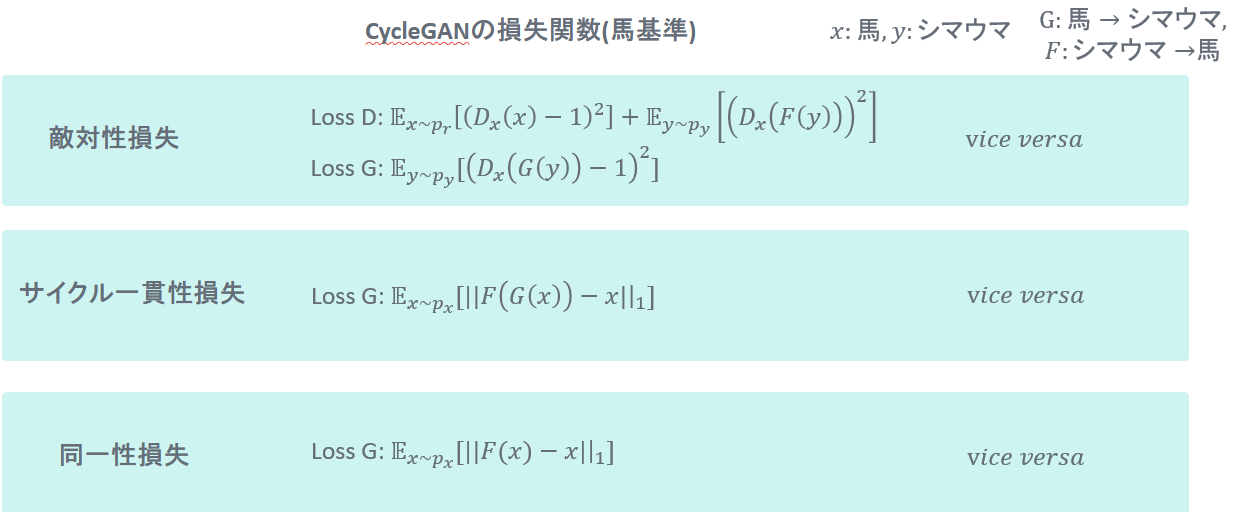

In [15]:
adversarial_loss = torch.nn.MSELoss().to(device)
cycle_loss = torch.nn.L1Loss().to(device)
identity_loss = torch.nn.L1Loss().to(device)

# 最適化の設定

In [16]:
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(opt.beta1, 0.999))
optimizer_G = optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                         lr=opt.lr, betas=(opt.beta1, 0.999))


In [17]:
lr_lambda = DecayLR(opt.n_epoch, 0, opt.decay_start).step
lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lr_lambda)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=lr_lambda)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=lr_lambda)

In [18]:
import os
model_name = "CycleGAN"
f_path_result = "./drive/MyDrive/result/{}".format(model_name)
f_path_params = "./drive/MyDrive/params/{}".format(model_name)

os.makedirs(f_path_result, exist_ok=True)
os.makedirs(f_path_params, exist_ok=True)

In [19]:
def save_params(epoch, dir_path, model_list, model_name_list):
    for model, model_name in zip(model_list, model_name_list):
      file_path = dir_path + "/{model}_{epoch}.pth".format(model = model_name, epoch=epoch) # Format filename outside torch.save
      torch.save(model.state_dict(), file_path)

  0%|          | 0/1334 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/instancenorm.py:115: UserWarning: input's size at dim=1 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(
100%|██████████| 1334/1334 [12:46<00:00,  1.74it/s]


epoch:0, Loss D:0.20477303008939352, Loss G GAN:8.717627136424921,
                  Loss G cycle:0.4406116160551026, Loss G identity:0.26756350691339514


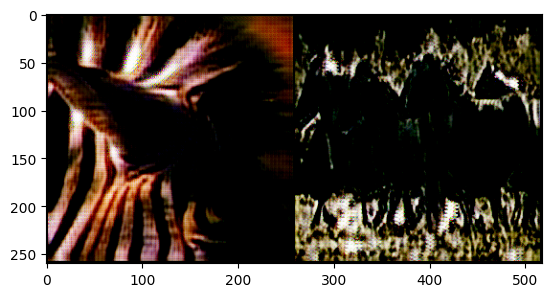

100%|██████████| 1334/1334 [06:08<00:00,  3.62it/s]


epoch:1, Loss D:0.19954885035757003, Loss G GAN:7.328217743397474,
                  Loss G cycle:0.4206187256155812, Loss G identity:0.22194698677751526


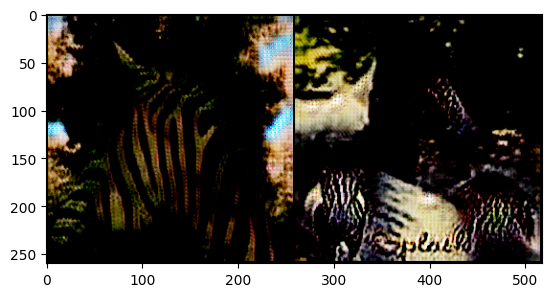

100%|██████████| 1334/1334 [03:39<00:00,  6.08it/s]


epoch:2, Loss D:0.197735794748205, Loss G GAN:6.775786924934101,
                  Loss G cycle:0.4206521115446869, Loss G identity:0.20314590425985954


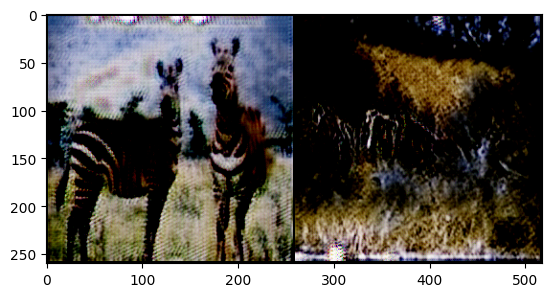

100%|██████████| 1334/1334 [02:50<00:00,  7.83it/s]


epoch:3, Loss D:0.18490572250128004, Loss G GAN:6.6296865566559635,
                  Loss G cycle:0.446794529254162, Loss G identity:0.19667597862890457


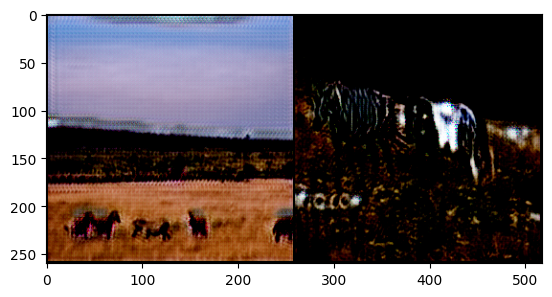

100%|██████████| 1334/1334 [02:32<00:00,  8.75it/s]


epoch:4, Loss D:0.18768311402791532, Loss G GAN:6.42402807508094,
                  Loss G cycle:0.4632249830131417, Loss G identity:0.18879236939685723


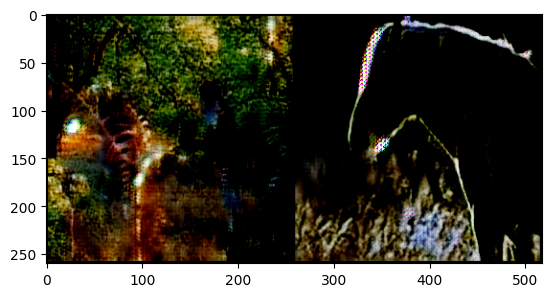

 28%|██▊       | 371/1334 [00:42<03:36,  4.44it/s]

In [ ]:
# Training
fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

for epoch in range(0, opt.n_epoch):
    running_loss_D = 0.0
    running_loss_G = 0.0
    running_loss_G_GAN = 0.0
    running_loss_G_cycle = 0.0
    running_loss_G_identity = 0.0
    for data in tqdm.tqdm(dataloader, position=0):
        real_img_A = data["A"].to(device)
        real_img_B = data["B"].to(device)
        batch_size = real_img_A.size()[0]
        real_label = torch.ones([batch_size, 1]).to(device)
        fake_label = torch.zeros([batch_size, 1]).to(device)
        #
        # Train Generator
        #
        optimizer_G.zero_grad()
        # adversarial loss
        fake_img_A = netG_B2A(real_img_B) # 馬のフェイクを生成(シマウマを入れて馬にしたもの)
        fake_img_B = netG_A2B(real_img_A) # シマウマのフェイクを生成(馬を入れてシマウマにしたもの)
        output_A = netD_A(fake_img_A) # 馬のフェイクを　馬識別器にいれて　馬判定を目指す
        output_B = netD_B(fake_img_B) # シマウマのフェイクを　シマウマ識別器にいれて　シマウマ判定を目指す

        loss_GAN_A2B = adversarial_loss(output_B, real_label)
        loss_GAN_B2A = adversarial_loss(output_A, real_label)

        #
        # cycle loss
        #
        cycle_img_A = netG_B2A(fake_img_B) # シマウマのフェイクをシマウマ→馬生成器に入力する
        cycle_img_B = netG_A2B(fake_img_A) # 馬のフェイクを馬→シマウマ生成器に入力する

        loss_cycle_ABA = cycle_loss(cycle_img_A, real_img_A) #　シマウマフェイク→馬　と　元の馬を判定
        loss_cycle_BAB = cycle_loss(cycle_img_B, real_img_B) #　馬フェイク→シマウマ　と　元のシマウマを判定（L1ノルムマンハッタン距離で各ピクセルのch差分の最小化）
        #
        # identity loss
        #
        identity_img_A = netG_B2A(real_img_A)
        identity_img_B = netG_A2B(real_img_B)
        loss_identity_A = identity_loss(identity_img_A, real_img_A)
        loss_identity_B = identity_loss(identity_img_B, real_img_B)

        lossG = ( loss_GAN_A2B + loss_GAN_B2A +
                 opt.weight_identity * (loss_identity_A + loss_identity_B) +
                 opt.weight_cycle * (loss_cycle_ABA + loss_cycle_BAB) )
        #生成器の学習に重きを置くことで、識別器の学習速度とバランスを取る役割を果たします。
        #CycleGANでは、識別器が早く学習してしまうため、サイクル同一性損失を強化することで生成器がより安定してリアルな変換を行えるようにする、
        #という意図が含まれています。(weight_identity=5 < weight_cycle=10)
        lossG.backward()
        optimizer_G.step()

        #
        # train Discriminator
        #
        optimizer_D_A.zero_grad()
        optimizer_D_B.zero_grad()

        real_output_A = netD_A(real_img_A)
        real_output_B = netD_B(real_img_B)
        loss_DA_real = adversarial_loss(real_output_A, real_label)
        loss_DB_real = adversarial_loss(real_output_B, real_label)

        fake_img_A = fake_A_buffer.push_and_pop(fake_img_A)
        fake_img_B = fake_B_buffer.push_and_pop(fake_img_B)
        fake_output_A = netD_A(fake_img_A.detach())
        fake_output_B = netD_B(fake_img_B.detach())

        loss_DA_fake = adversarial_loss(fake_output_A, fake_label)
        loss_DB_fake = adversarial_loss(fake_output_B, fake_label)

        loss_DA = (loss_DA_real + loss_DA_fake) * 0.5
        loss_DB = (loss_DB_real + loss_DB_fake) * 0.5

        loss_DA.backward()
        loss_DB.backward()
        optimizer_D_A.step()
        optimizer_D_B.step()
        #
        # adding to running loss
        #
        running_loss_D += (loss_DA.item() + loss_DB.item()) / 2.0
        running_loss_G += lossG.item()
        running_loss_G_GAN += (loss_GAN_A2B.item() + loss_GAN_B2A.item()) / 2.0
        running_loss_G_cycle += (loss_cycle_ABA.item() + loss_cycle_BAB.item()) / 2.0
        running_loss_G_identity += (loss_identity_A.item() + loss_identity_B.item()) / 2.0
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    running_loss_D /= len(dataloader)
    running_loss_G /= len(dataloader)
    running_loss_G_GAN /= len(dataloader)
    running_loss_G_cycle /= len(dataloader)
    running_loss_G_identity /= len(dataloader)
    loss_log = """epoch:{}, Loss D:{}, Loss G GAN:{},
                  Loss G cycle:{}, Loss G identity:{}""".format(epoch, running_loss_D,running_loss_G,running_loss_G_GAN,running_loss_G_cycle,running_loss_G_identity)
    print(loss_log)
    fake_imgs = torch.cat([fake_img_A, fake_img_B])
    grdi_imgs = vutils.make_grid(fake_imgs.detach())
    grdi_imgs_arr = grdi_imgs.cpu().numpy()
    plt.imshow(np.transpose(grdi_imgs_arr,(1,2,0)))
    plt.show()
    model_list = [netG_A2B, netG_B2A, netD_A, netD_B]
    model_name_list = ["netG_A2B", "netG_B2A", "netD_A", "netD_B"]
    save_params(epoch, f_path_params, model_list, model_name_list)